# EMA adherence

Kendra Wyant  
September 18, 2024

Purpose: This file calculates overall weekly EMA adherence using EMA survey data (`survey_daily.csv`).

## Set up

In [ ]:
#| message: false

options(conflicts.policy = "depends.ok")
library(tidyverse) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

### Data

In [ ]:
ema <- read_csv(here::here(path_shared, "survey_daily.csv"),
                show_col_types = FALSE) |> 
  mutate(start_date = as_datetime(start_date, tz = "America/Chicago"))

burden_quant <- read_csv(here::here(path_burden, "burden_quant.csv"),
                   show_col_types = FALSE)
burden_qual <- read_csv(here::here(path_burden, "burden_qual.csv"),
                   show_col_types = FALSE)

subids

In [ ]:
subids <- burden_quant |> 
  select(subid) |> 
  bind_rows(burden_qual |> 
              select(subid)) |> 
  pull(subid) |>
  unique()

Filter ema to burden subids

In [ ]:
ema <- ema |>
  filter(subid %in% subids)

### Overall Adherence

Data still in long format so slicing to single variable on survey

In [ ]:
ema <- ema |> 
  group_by(subid, start_date) |> 
  slice(1) |> 
  ungroup()

Study start and end dates for each subid

In [ ]:
study_start <- ema |> 
  group_by(subid) |> 
  arrange(start_date) |> 
  slice(1) |> 
  ungroup() |> 
  mutate(study_start = as_date(start_date)) |> 
  select(subid, study_start)

study_end <- ema |> 
  group_by(subid) |> 
  arrange(desc(start_date)) |> 
  slice(1) |> 
  ungroup() |> 
  mutate(study_end = as_date(start_date)) |> 
  select(subid, study_end)

dates <- tibble(subid = subids) |> 
  full_join(study_start, by = "subid") |> 
  full_join(study_end, by = "subid")

In [ ]:
dates |> 
  select(study_start, study_end) |> 
  skimr::skim()

  ---------------------------------------------------------------------------------------------
  skim_variable     n_missing   complete_rate min          max          median         n_unique
  --------------- ----------- --------------- ------------ ------------ ------------ ----------
  study_start               0               1 2003-04-21   2023-12-20   2022-11-30          197

  study_end                 0               1 2022-04-05   2024-05-01   2023-10-31          146
  ---------------------------------------------------------------------------------------------


Subid 1146 has incorrect start year. Formatting issue with first EMA - remove this survey for calculating dates.

In [ ]:
ema |> 
  filter(subid == 1146)

# A tibble: 242 × 9
   subid user_survey_guid    start_date          complete_date status utc_offset
   <dbl> <chr>               <dttm>                      <dbl> <chr>  <chr>     
 1  1146 0b4ef392-61ef-4631… 2003-04-21 15:54:28           -1  incom… "{\"utc_o…
 2  1146 4de9d05a-ba2e-41a9… 2022-08-16 12:42:25   1660672214. compl… "{\"utc_o…
 3  1146 da1e87ed-6f87-4a4a… 2022-08-17 12:46:31   1660758482. compl… "{\"utc_o…
 4  1146 c34872a2-3ffa-4bec… 2022-08-18 12:45:10   1660845108. compl… "{\"utc_o…
 5  1146 a4388ae0-1422-49fe… 2022-08-19 16:41:41   1660945424. compl… "{\"utc_o…
 6  1146 c5780e26-accc-4a41… 2022-08-20 13:38:39   1661020845. compl… "{\"utc_o…
 7  1146 ad9fb4d4-c10e-4fe1… 2022-08-21 16:11:17   1661116421. compl… "{\"utc_o…
 8  1146 35983c35-a6f2-4e3e… 2022-08-22 19:42:38           -1  incom… "{\"utc_o…
 9  1146 f8b82f7f-caac-4b68… 2022-08-23 10:57:44   1661270349. compl… "{\"utc_o…
10  1146 7de068b0-6a3b-414b… 2022-08-24 17:19:08   1661379606. compl… "{\"utc_o…
# ℹ 232 

Recalculate study start and end dates

In [ ]:
study_start <- ema |> 
  group_by(subid) |> 
  arrange(start_date) |> 
  slice(1) |> 
  ungroup() |> 
  mutate(study_start = as_date(start_date)) |> 
  select(subid, study_start)

study_end <- ema |> 
  group_by(subid) |> 
  arrange(desc(start_date)) |> 
  slice(1) |> 
  ungroup() |> 
  mutate(study_end = as_date(start_date)) |> 
  select(subid, study_end)

dates <- tibble(subid = subids) |> 
  full_join(study_start, by = "subid") |> 
  full_join(study_end, by = "subid")

Get all study days for each subid

In [ ]:
# function to map over
get_study_days <- function(the_subid, dates) {
  study_start <- dates |>  filter(subid == the_subid) |>  pull(study_start)
  study_end <- dates |>  filter(subid == the_subid) |> pull(study_end)
  study_days <- tibble(subid = the_subid, study_day = seq(study_start, study_end - days(1), by = "day")) 
  return(study_days)
}

study_dates <- subids |> 
  map_dfr(~get_study_days(.x, dates))

Count surveys per study day (day starts at 6 am)

In [ ]:
ema_count <- ema |>
  mutate(study_day = if_else(hour(start_date) >= 6, 
                        as_date(start_date),
                        as_date(start_date) - days(1))) |> 
  count(subid, study_day) 


ema_count <- ema_count |> 
  mutate(n = if_else(n > 1, 1, n))

Add counts to study dates

In [ ]:
count_study_dates <- study_dates |> 
  left_join(ema_count, by = c("subid", "study_day")) |> 
  mutate(n = if_else(is.na(n), 0, n)) |> 
  mutate(n_prompts = 1) 

calculate mean adherence

In [ ]:
mean_ema <- count_study_dates |> 
  group_by(subid) |> 
  summarize(n_total = sum(n), prompt_total = sum(n_prompts)) |> 
  mutate(mean = n_total/prompt_total) |> 
  ungroup() |> 
  summarize(mean = mean(mean))

On average participants (N = 247) completed 0.75 daily surveys each day they were on study. That is their overall adherence for a once daily EMA was 75%.

Hist of overall adherence by subid

ℹ Please use `linewidth` instead.

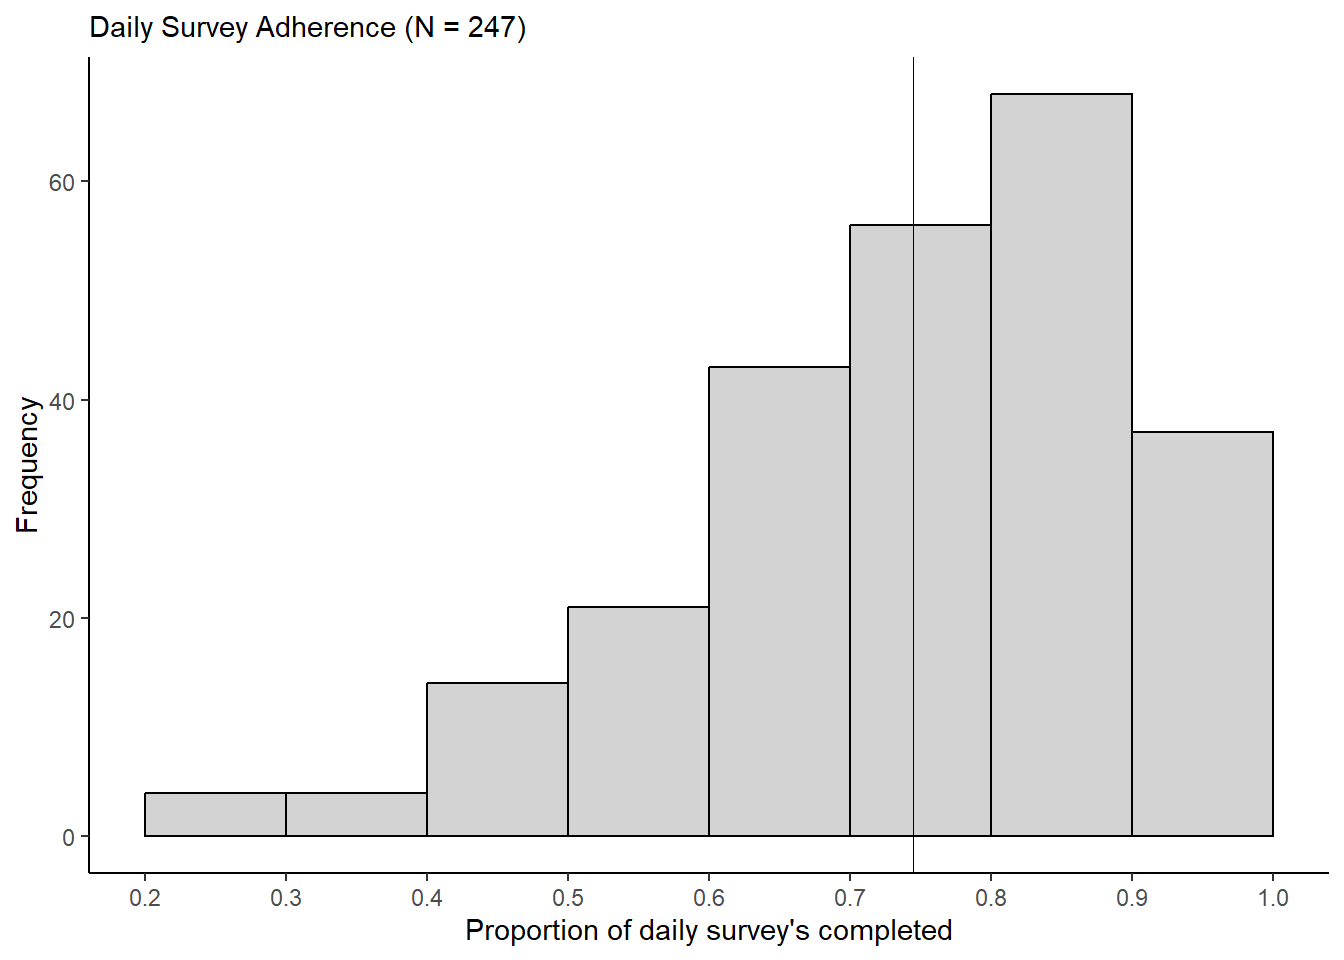

In [ ]:
count_study_dates |> 
  group_by(subid) |> 
  summarise(n_total = sum(n),
            n_prompts = sum(n_prompts)) |> 
  mutate(adherence = n_total/n_prompts) |> 
  ggplot(aes(x = adherence)) +
  geom_histogram(color = "black", fill = "light grey", binwidth = .1, center = .55) +
  scale_x_continuous(breaks = c(0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0)) +
  labs(y = "Frequency", x = "Proportion of daily survey's completed",
       subtitle = "Daily Survey Adherence (N = 247)") +
  geom_vline(aes(xintercept = mean_ema$mean), size = .3) +
  theme_classic()

## Adherence over time

Quite a few people have over 365 days of EMA. **Lose these in adherence over 12 month plot**.

In [ ]:
dates |> 
  mutate(n = study_end - study_start) |> 
  arrange(desc(n)) |> 
  filter(n > 365) |> 
  print(n = Inf)

# A tibble: 52 × 4
   subid study_start study_end  n       
   <dbl> <date>      <date>     <drtn>  
 1  1152 2022-09-06  2023-10-27 416 days
 2  1200 2022-11-01  2023-12-22 416 days
 3  1146 2022-08-16  2023-10-03 413 days
 4  1286 2023-02-28  2024-04-12 409 days
 5  1211 2022-11-17  2023-12-27 405 days
 6  1080 2022-05-10  2023-06-17 403 days
 7  1197 2022-10-31  2023-12-08 403 days
 8  1168 2022-10-03  2023-10-31 393 days
 9  1035 2022-03-07  2023-04-01 390 days
10  1071 2022-04-29  2023-05-23 389 days
11  1036 2022-03-11  2023-04-03 388 days
12  1044 2022-03-25  2023-04-17 388 days
13  1302 2023-03-16  2024-04-07 388 days
14  1029 2022-02-21  2023-03-15 387 days
15  1030 2022-02-23  2023-03-16 386 days
16  1046 2022-03-28  2023-04-18 386 days
17  1122 2022-07-11  2023-08-01 386 days
18  1249 2023-01-10  2024-01-31 386 days
19  1012 2021-09-15  2022-10-05 385 days
20  1112 2022-06-27  2023-07-17 385 days
21  1148 2022-08-19  2023-09-08 385 days
22  1033 2022-03-03  2023-03-22 384 da

Slice into 30 day bins

In [ ]:
study_months <- count_study_dates |> 
  group_by(subid) |> 
  slice(1:30) |> 
  mutate(month = 1) |> 
  bind_rows(count_study_dates |> 
    group_by(subid) |> 
    slice(31:60) |> 
    mutate(month = 2)) |> 
  bind_rows(count_study_dates |> 
    group_by(subid) |> 
    slice(61:90) |> 
    mutate(month = 3)) |> 
  bind_rows(count_study_dates |> 
    group_by(subid) |> 
    slice(91:120) |> 
    mutate(month = 4)) |> 
  bind_rows(count_study_dates |> 
    group_by(subid) |> 
    slice(121:150) |> 
    mutate(month = 5)) |> 
  bind_rows(count_study_dates |> 
    group_by(subid) |> 
    slice(151:180) |> 
    mutate(month = 6)) |> 
  bind_rows(count_study_dates |> 
    group_by(subid) |> 
    slice(181:210) |> 
    mutate(month = 7)) |> 
  bind_rows(count_study_dates |> 
    group_by(subid) |> 
    slice(211:240) |> 
    mutate(month = 8)) |> 
  bind_rows(count_study_dates |> 
    group_by(subid) |> 
    slice(241:270) |> 
    mutate(month = 9)) |> 
  bind_rows(count_study_dates |> 
    group_by(subid) |> 
    slice(271:300) |> 
    mutate(month = 10)) |> 
  bind_rows(count_study_dates |> 
    group_by(subid) |> 
    slice(301:330) |> 
    mutate(month = 11)) |> 
  bind_rows(count_study_dates |> 
    group_by(subid) |> 
    slice(331:360) |> 
    mutate(month = 12)) |> 
  ungroup()

Get individual adherence scores

In [ ]:
ema_month_adherence <- study_months |> 
  group_by(subid, month) |> 
  summarize(sum_n = sum(n), sum_prompts = sum(n_prompts), .groups = "rowwise") |> 
  mutate(adherence = sum_n/sum_prompts) |> 
  ungroup()

Summarize total adherence

In [ ]:
ema_month_adherence |> 
  group_by(month) |> 
  summarize(mean_adherence = mean(adherence)) 

# A tibble: 12 × 2
   month mean_adherence
   <dbl>          <dbl>
 1     1          0.840
 2     2          0.813
 3     3          0.790
 4     4          0.753
 5     5          0.744
 6     6          0.746
 7     7          0.731
 8     8          0.724
 9     9          0.698
10    10          0.704
11    11          0.688
12    12          0.691

Plot adherence by month

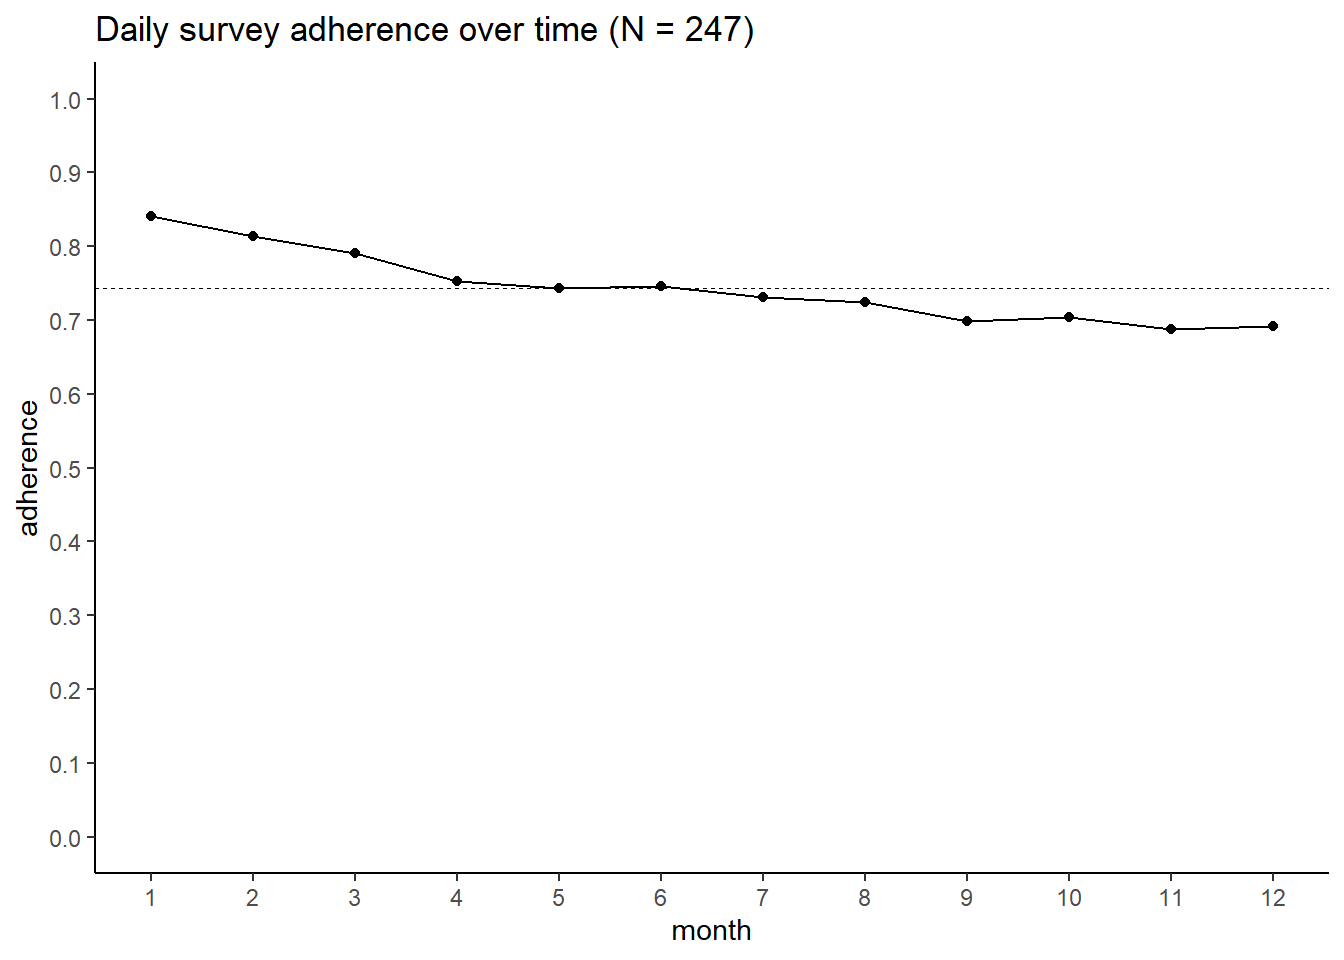

In [ ]:
ema_month_adherence |> 
  group_by(month) |> 
  summarize(mean_adherence = mean(adherence)) |> 
  ggplot(aes(x = month, y = mean_adherence)) +
  geom_point() +
  geom_line() +
  theme_classic() +
  scale_x_continuous(name = "month", 
                     breaks = seq(1, 12, 1)) +
  scale_y_continuous(name = "adherence", 
                     breaks = seq(0, 1, .1), 
                     limits = c(0, 1)) +
  labs(title = "Daily survey adherence over time (N = 247) ") +
  theme(legend.title = element_blank()) +
  geom_hline(aes(yintercept = mean(mean_adherence)), linetype = "dashed", size = .3)